Columns in dataset: ['Month', '#Passengers']

First 5 rows:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

Data summary:
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


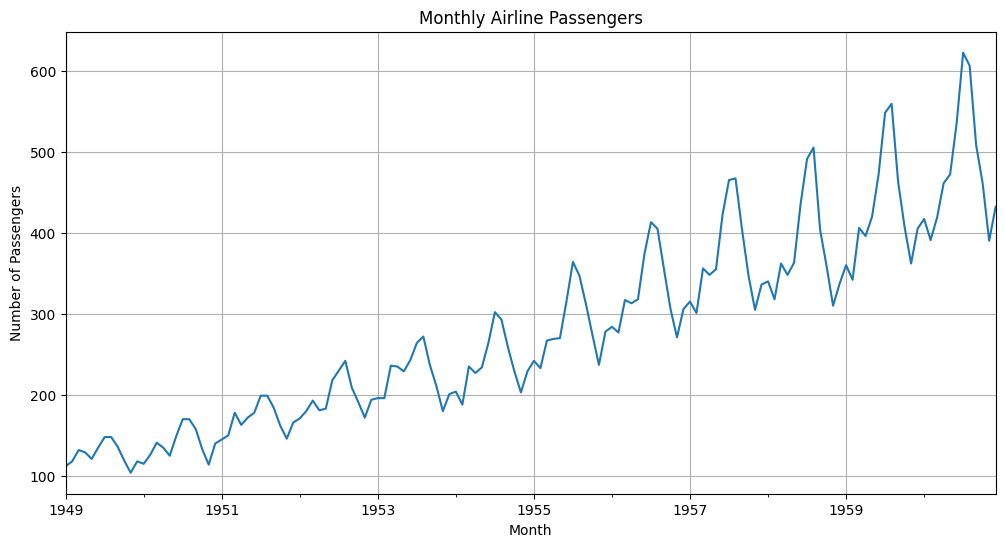


Stationarity Test - Original Data:
ADF Statistic: 0.8153688792060475
p-value: 0.991880243437641
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598

Stationarity Test - First Difference:
ADF Statistic: -2.829266824170006
p-value: 0.05421329028382468
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


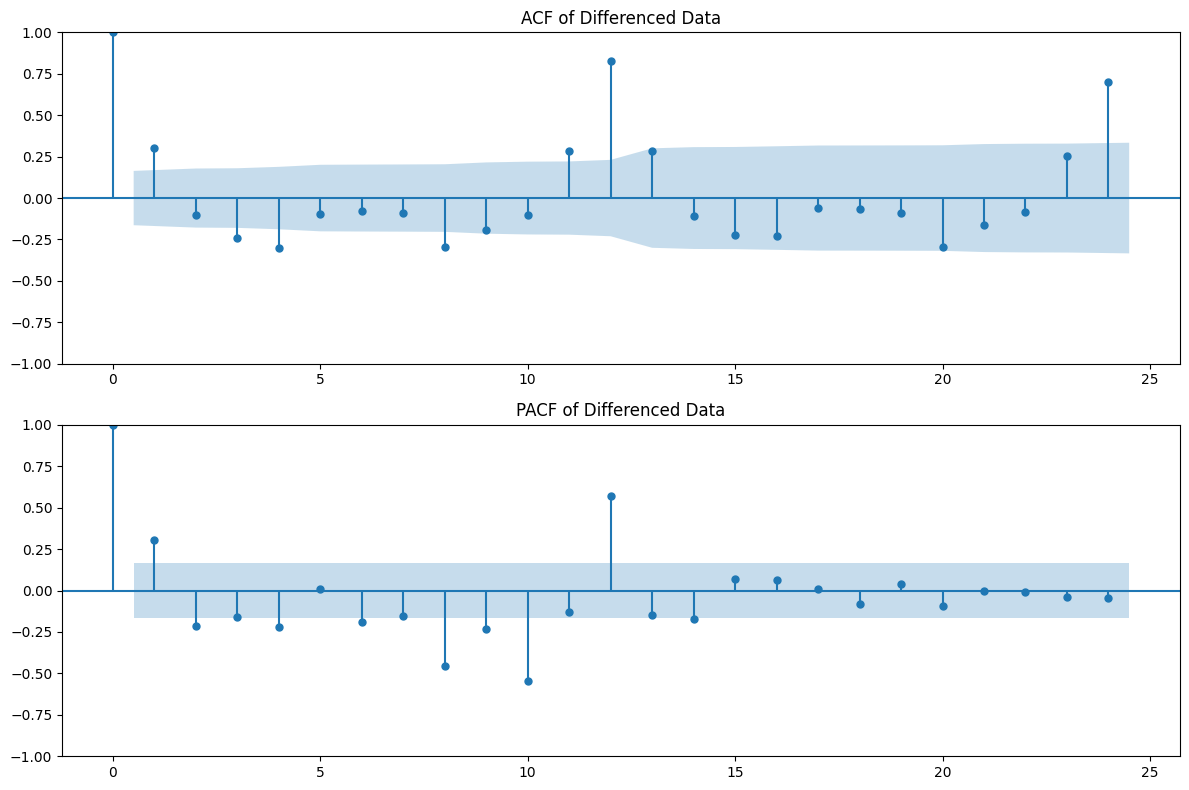

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -456.103
Date:                            Wed, 16 Apr 2025   AIC                            922.205
Time:                                    00:36:37   BIC                            936.016
Sample:                                01-01-1949   HQIC                           927.812
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2298      0.401     -0.573      0.567      -1.016       0.557
ma.L1         -0.09

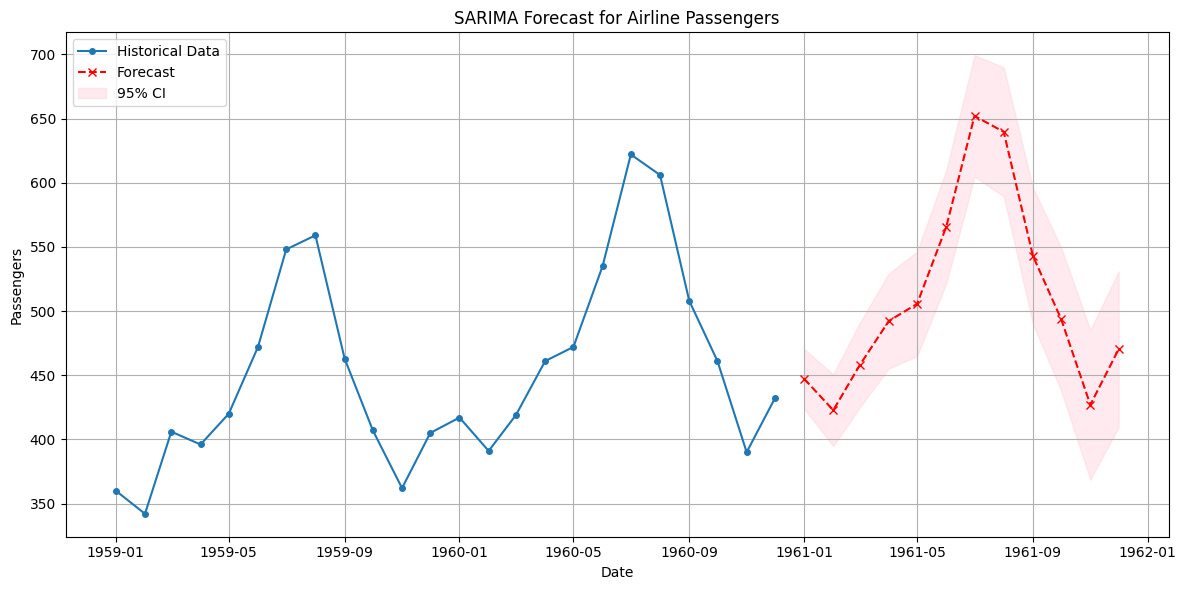


Forecasted Passengers:
            Forecast  Lower Bound  Upper Bound
1961-01-01     447.0        424.0        470.0
1961-02-01     423.0        395.0        451.0
1961-03-01     458.0        425.0        491.0
1961-04-01     492.0        455.0        529.0
1961-05-01     506.0        465.0        546.0
1961-06-01     566.0        522.0        610.0
1961-07-01     652.0        605.0        699.0
1961-08-01     640.0        589.0        690.0
1961-09-01     543.0        490.0        596.0
1961-10-01     494.0        438.0        549.0
1961-11-01     427.0        369.0        485.0
1961-12-01     470.0        409.0        531.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt

# --- Configuration ---
file_path = 'C:/Users/USER/Downloads/AirPassengers.csv'
date_column = 'Month'
value_column = '#Passengers'
date_format = '%Y-%m'
seasonal_period = 12
forecast_steps = 12
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# --- Load and prepare data ---
try:
    df = pd.read_csv(file_path)
    print("Columns in dataset:", df.columns.tolist())
    
    # Convert date and set index
    df[date_column] = pd.to_datetime(df[date_column], format=date_format)
    df.set_index(date_column, inplace=True)
    df = df[[value_column]].sort_index()
    
    # Handle missing/infinite values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData summary:")
    print(df.describe())

except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- Exploratory Analysis ---
plt.figure(figsize=(12, 6))
df[value_column].plot(title='Monthly Airline Passengers')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

# --- Enhanced Stationarity Test ---
def test_stationarity(series, title="Data"):
    """Robust stationarity test with NaN/inf checking"""
    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(series) < 2:
        print(f"Cannot test stationarity - not enough data points for {title}")
        return
    
    print(f"\nStationarity Test - {title}:")
    try:
        result = adfuller(series)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print(f"   {key}: {value}")
    except Exception as e:
        print(f"Error in stationarity test: {e}")

# Test original data
test_stationarity(df[value_column], "Original Data")

# Create and test differenced series
df_diff = df[value_column].diff().dropna()
test_stationarity(df_diff, "First Difference")

# --- ACF/PACF Analysis ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=24, ax=ax1, title='ACF of Differenced Data')
plot_pacf(df_diff, lags=24, ax=ax2, title='PACF of Differenced Data')
plt.tight_layout()
plt.show()

# --- SARIMA Modeling ---
try:
    # Fit model with error handling
    model = SARIMAX(df[value_column],
                   order=sarima_order,
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False)
    
    results = model.fit(disp=False)
    print("\nModel Summary:")
    print(results.summary())

    # Generate forecast with confidence intervals
    forecast = results.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Create forecast dates
    last_date = df.index[-1]
    forecast_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=forecast_steps,
        freq='MS'
    )
    
    # --- Plot Results ---
    plt.figure(figsize=(12, 6))
    
    # Plot last 2 years of historical data
    plt.plot(df.index[-24:], df[value_column][-24:], 
             label='Historical Data', marker='o', markersize=4)
    
    # Plot forecast
    plt.plot(forecast_dates, forecast_values, 
             'r--', label='Forecast', marker='x')
    
    # Plot confidence intervals
    plt.fill_between(forecast_dates,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='pink', alpha=0.3, label='95% CI')
    
    plt.title(f'SARIMA Forecast for Airline Passengers')
    plt.xlabel('Date')
    plt.ylabel('Passengers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print forecast table
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values.round(),
        'Lower Bound': conf_int.iloc[:, 0].round(),
        'Upper Bound': conf_int.iloc[:, 1].round()
    }, index=forecast_dates)
    
    print("\nForecasted Passengers:")
    print(forecast_df)

except Exception as e:
    print(f"\nModeling Error: {e}")
    print("\nTroubleshooting Tips:")
    print("1. Check for NaN/inf values in your data")
    print("2. Try simpler model orders like (0,1,1)(0,1,1,12)")
    print("3. Consider seasonal decomposition first")
    print("4. Verify your data has enough observations (at least 2-3 seasonal cycles)")